In [1]:
import numpy as np
import regex as re
import pandas as pd
import glob
import random 
import tensorflow as tf
from collections import Counter

import nltk
from sklearn.model_selection import StratifiedShuffleSplit
from nltk.tokenize import TweetTokenizer

from keras.layers import Dense, Embedding, Flatten, Input, concatenate, average, minimum, maximum, add
from keras.models import Model
from keras.optimizers import Adagrad
from keras.preprocessing.sequence import pad_sequences

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval

from textblob import TextBlob

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
output= 'output_trainTestData/'
outputpath ='outputs/05_randomize_samEval2018/'

# Load, randomize, decode and store data

In [4]:
#Load data, split random in train and test set, create pos and sentiment features
TRAIN_SAMEVAL = path + 'SemEval2018-T3-train-taskA_emoji.txt'
GOLD_TEST_SAMEVAL  = path + 'SemEval2018-T3_gold_test_taskA_emoji.txt'

def read_data_samEval(FILENAME):
    labels = []
    corpus = []   
    with open(FILENAME, 'r', encoding='utf-8') as train: #Decoding utf-8, else exception
        for line in train:
            if not line.lower().startswith("tweet index"): #skip header
                line = line.rstrip().split("\t")
                label = line[1] #erste Spalte - label
                labels.append(int(label))
                tweet = line[2] #zweite Spalte - tweet
                corpus.append(tweet)  
    returnvalue = []
    returnvalue.append(labels)
    returnvalue.append(corpus)
    return returnvalue

resulttrain = read_data_samEval(TRAIN_SAMEVAL)
resulttest = read_data_samEval(GOLD_TEST_SAMEVAL)

corpus = np.concatenate([resulttrain, resulttest], axis = -1)

#Randomize the data with balanced class distribution
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=7)

data = corpus[1]
labels = corpus[0]

for train_index, test_index in stratSplit.split(data, labels):
    traindata = data[train_index]
    testdata = data[test_index]
    trainlabels = labels[train_index]
    testlabels = labels[test_index]

In [5]:
#Prepocess the data
def text_to_wordlist(tweet, vocab):
    #Remove hashtags
    tweet = re.sub('#','', tweet)
    
    #Remove usermentions
    tweet= re.sub(r'(\w+|^|)@\w+','', tweet)
    
    #Treats url's as special tokens (actually twitter specific)
    tweet=re.sub(r'((http|https)://)(\w|[.]|/)+', 'URL', tweet)
    
    #Tokenize
    tokenizer = TweetTokenizer()
    tweet = tokenizer.tokenize(tweet)
    
    vocab.update(tweet)
    return tweet

vocab = Counter()
tweets_sameval = np.concatenate([traindata ,testdata])

alltweets = []
for tweet in tweets_sameval:
    twt = text_to_wordlist(tweet, vocab)
    alltweets.append(twt)

In [6]:
#Create train data, test data and word_index
def create_train_test_wordindex(vocab, tweets, corpustrain):
    MAX_NB_WORDS = len(vocab)

    MAX_SEQUENCE_LENGTH= 0
    for tweet in tweets:
        if len(tweet) > MAX_SEQUENCE_LENGTH:
            MAX_SEQUENCE_LENGTH = len(tweet)
            
    print('Maximal Sequence Length: '+str(MAX_SEQUENCE_LENGTH))

    word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

    sequences = [[word_index.get(t, 0) for t in tweet]
                 for tweet in tweets[:len(corpustrain)]]

    test_sequences = [[word_index.get(t, 0) for t in tweet] 
                      for tweet in tweets[len(corpustrain):]]

    train_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                         padding="pre", truncating="post")

    test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                              truncating="post")

    return train_data, test_data, word_index

train_data, test_data, word_index = create_train_test_wordindex(vocab, alltweets, traindata)

Maximal Sequence Length: 40


In [7]:
#Store data, labels and word_index for reproducability
def write_file(filename, data):
    file_present = glob.glob(filename)
    if not file_present:
        pd.DataFrame(data).to_csv(filename, header=None, index=None)
    else:
        print('Warining: File '+str(filename)+' already exists.')
        
def write_index(filename, index):
    file_present = glob.glob(filename)
    if not file_present:
        f = open(filename, 'w+', encoding="utf-8")
        isnew = True
        for key, value in index.items():
            if isnew:
                f.write(str(key)+'\t'+str(value))
                isnew = False
            else:
                f.write('\n'+str(key)+'\t'+str(value))
        f.close()
    else:
        print('Warining: File '+str(filename)+' already exists.')
    
write_file(output+'samEval_randomized_train_data.csv', train_data)
write_file(output+'samEval_randomized_train_labels.csv', trainlabels)
write_file(output+'samEval_randomized_test_data.csv', test_data)
write_file(output+'samEval_randomized_test_labels.csv', testlabels)
write_index(output+'samEval_randomized_word_index.csv', word_index)

In [ ]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

# Aditional features

In [11]:
def reconstruct(index_file, data_file):
   
    loaded_word_index = {}
    with open(index_file, 'r', encoding='utf-8') as word_index: #Decoding utf-8, else exception
        for line in word_index:
            line = line.rstrip().split("\t")
            loaded_word_index[line[0]] = line[1]  
            
    loaded_data =[]
    with open(data_file, 'r', encoding='utf-8') as data: #Decoding utf-8, else exception
        for line in data:
            line = line.rstrip().split('\n')
            loaded_data.append(line) 
            
    recunstructed_data = []
    for line in loaded_data:
        for string in line:
            tweet = []
            string = string.rstrip().split(',')
            for item in string:
                if item is not ('0'):
                    for key, value in loaded_word_index.items():
                        if value == item:
                            tweet.append(key)
            recunstructed_data.append(tweet)
        
    return recunstructed_data

In [12]:
#Create POS
def create_pos_sequence(index_file, data_file, MAXLEN):
   
    recunstructed_data = reconstruct(index_file, data_file)
            
    pos = []
    pos_list = []
    for entry in recunstructed_data:
        postags = nltk.pos_tag(entry)
        for tag in postags:
            if tag[1] not in pos_list:
                pos_list.append(tag[1])
        pos.append(postags)
        
    pos_dict ={}
    i = 1

    for entry in pos_list:
        pos_dict[entry] = i
        i += 1
        
    decoded_pos =[]
    for entry in pos:
        tweet = []
        for tup in entry:
            decode = pos_dict.get(tup[1])
            tweet.append(decode)
        decoded_pos.append(tweet)
        
    pos_sequences = pad_sequences(decoded_pos, maxlen=MAXLEN,padding="pre", truncating="post")
    
    return pos_sequences

def write_pos_file(filename, data):
    file_present = glob.glob(filename)
    if not file_present:
        pd.DataFrame(data).to_csv(filename, header=None, index=None)
    else:
        print('Warining: File '+str(filename)+' already exists.')

train_pos = create_pos_sequence(output+'samEval_randomized_word_index.csv',output+'samEval_randomized_train_data.csv', 40)
write_pos_file(output+'samEval_randomized_train_pos.csv', train_pos)

test_pos = create_pos_sequence(output+'samEval_randomized_word_index.csv',output+'samEval_randomized_test_data.csv', 40)
write_pos_file(output+'samEval_randomized_test_pos.csv', test_pos)

In [13]:
#Create Sentiment
def blob_sentiment(data):
    sentiment_blob = []

    for entry in data:
        sentiment_line = []
        for word in entry:
            word = TextBlob(word)
            polarity = word.sentiment.polarity
            sentiment_line.append(polarity)
        sentiment_blob.append(sentiment_line)
    return sentiment_blob

def write_sentiment_file(filename, data, maxlength):
    #data_sequence = pad_sequences(data, maxlen=MAXLEN,padding="pre", truncating="post")
    file_present = glob.glob(filename)
    pad_data= pad_sequences(data, maxlen=maxlength,padding="pre", truncating="post", dtype='float32')
    if not file_present:
        pd.DataFrame(pad_data).to_csv(filename, header=None, index=None)
    else:
        print('Warining: File '+str(filename)+' already exists.')

rec_data = reconstruct(output+'samEval_randomized_word_index.csv', output+'samEval_randomized_train_data.csv')
sentiment_blob = blob_sentiment(rec_data)
write_sentiment_file(output+'samEval_randomize_train_data_sentiment_blob.csv', sentiment_blob, 40)

rec_data_test = reconstruct(output+'samEval_randomized_word_index.csv',output+'samEval_randomized_test_data.csv')
sentiment_blob_test = blob_sentiment(rec_data_test)
write_sentiment_file(output+'samEval_randomize_test_data_sentiment_blob.csv', sentiment_blob_test,40)

In [14]:
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

train_senti_blob =get_sentiment('output_trainTestData/samEval_randomize_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/samEval_randomize_test_data_sentiment_blob.csv')

### Hyperparameter for all models

In [15]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

# Train the model

In [16]:
#First part
MAX_SEQUENCE_LENGTH = 40
wv_layer = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = wv_layer(comment_input)
x_first = Dense(600, activation='relu')(embedded_sequences)
x_first = Flatten()(x_first)

#Second part
senti_input_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_second = Dense(600, activation='relu')(senti_input_blob)

#Thrid part
senti_input_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_third = Dense(600, activation='relu')(senti_input_pos)

#Concatination
concat = concatenate([x_first, x_second, x_third])

preds = Dense(2, activation='softmax')(concat)

model = Model(inputs=[comment_input, senti_input_blob, senti_input_pos], outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      4118700     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40, 600)      180600      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (I

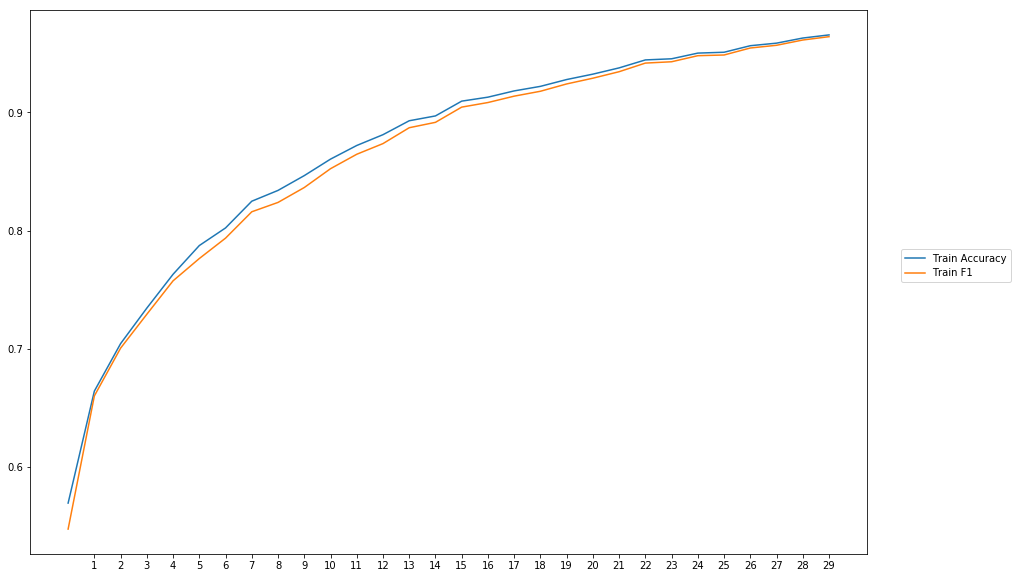


-----Test Scores----
Loss: 0.6676282820763526
Accuracy: 63.63636358475788
Precision: 62.05357140086895
Recall: 62.61261258440874
F1: 62.331833537171875


In [286]:
train_evaluate_three_inputs(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, trainlabels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'finalrandomize')

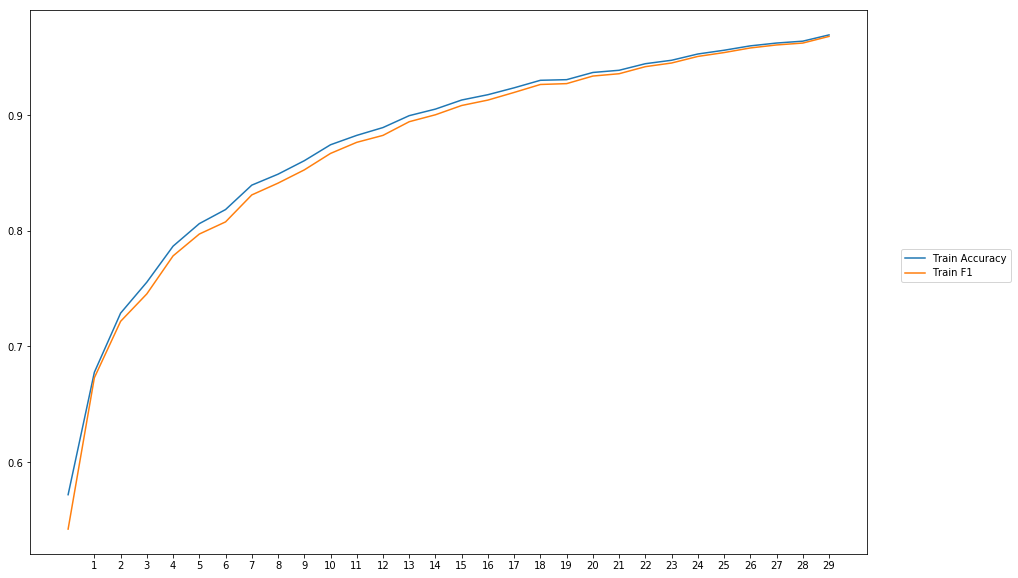


-----Test Scores----
Loss: 0.6777836711375744
Accuracy: 65.04328999168429
Precision: 64.66346152291744
Recall: 60.44943818866305
F1: 62.485476988835195


In [18]:
train_evaluate_three_inputs(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, trainlabels, test_data, test_senti_blob, test_pos, testlabels, softmax, outputpath, 'finalrandomize')